## Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import torch
import cv2 as cv
import json
import torchvision.transforms

## Read in Datasheet with references to images

In [3]:
df = pd.read_csv('FracAtlas/dataset.csv')

## Show example images

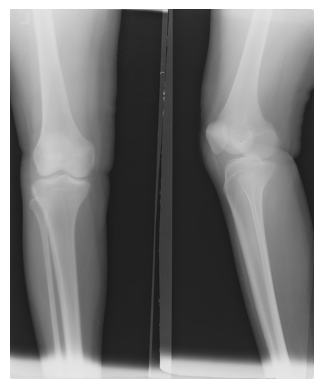

In [17]:
num_fracs = 0 #only show one example for each
num_non_fracs = 0
multi = 0


for index, row in df.iterrows():
    image_id = row['image_id']
    fractured_indicator = row['fractured']
    multi_indicator = row['multiscan']
    if fractured_indicator and multi_indicator:
        filename = f'FracAtlas/images/Fractured/{image_id}'
    else:
        filename = f'FracAtlas/images/Non_fractured/{image_id}'

    if num_fracs == 0 and fractured_indicator and multi == 0:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_fracs += 1
        multi += 1
    
    if num_non_fracs == 0 and not fractured_indicator and multi == 0:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_non_fracs += 1
        multi += 1

## Transform skeletal images to controlmaps to feed into controlnet and image generation
These controlmaps will be done using the process of image segmentation, generating an image that is easily reproducible by hand to feed into the controlnet and subsequent x-ray image generation.

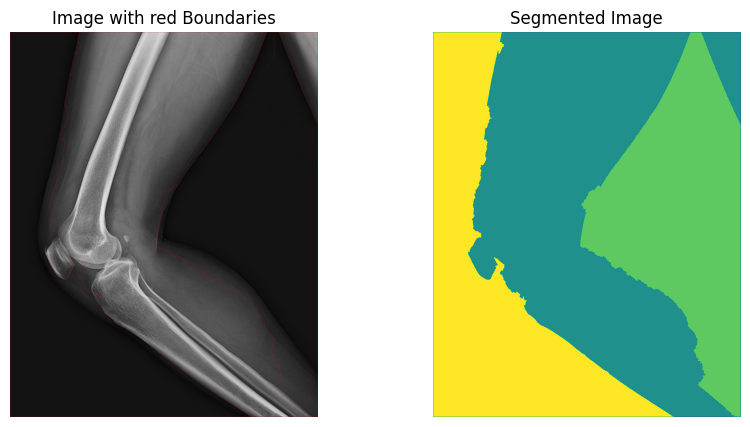

In [9]:
ex = df.loc[14]
image_id = ex['image_id']
fractured_indicator = ex['fractured']
print("This x-ray is of the ", ex[''])
if fractured_indicator:
    filename = f'FracAtlas/images/Fractured/{image_id}'
else:
    filename = f'FracAtlas/images/Non_fractured/{image_id}'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=(10, 5))  # Set the figure size as needed

# Display the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Image with red Boundaries')

# Display the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(markers)
plt.axis('off')
plt.title('Segmented Image')

# Show the plot
plt.show()


## Smooth edges of controlmaps
First attempt using blurring techniques to decrease granularity of controlmaps, kernel size can be adjusted accordingly

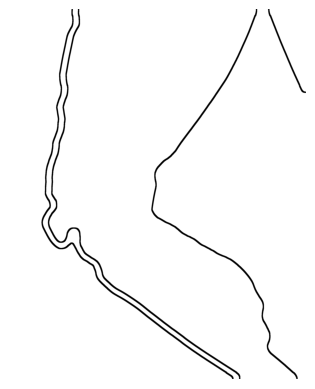

In [10]:
if markers.ndim == 2 or (markers.ndim == 3 and markers.shape[2] == 1):
    gray_img = markers  # It is already grayscale
else:
    gray_img = cv.cvtColor(markers, cv.COLOR_BGR2GRAY)

# Apply the blur
smoothed_gray_img = cv.blur(gray_img, (100, 100))

# Ensure the image is 8-bit
smoothed_gray_img = cv.convertScaleAbs(smoothed_gray_img)

v = np.median(smoothed_gray_img)

sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(smoothed_gray_img, lower, upper)

kernel = np.ones((10,10), np.uint8)  # Create a 3x3 matrix of ones
dilated_edges = cv.dilate(edges, kernel, iterations=1)

sketch = cv.bitwise_not(dilated_edges);

# Display the dilated edges
plt.imshow(sketch, cmap='gray')
plt.axis('off')
plt.show()

Going to first do tests on leg images since they are simpler to generate and the dataset has the most of it for any body part category. 2009 total non-fractured and 263 fractured images. Should filter out multiscans and limit fracture count to one with the associated label too. Frontal scans only for normalization purposes

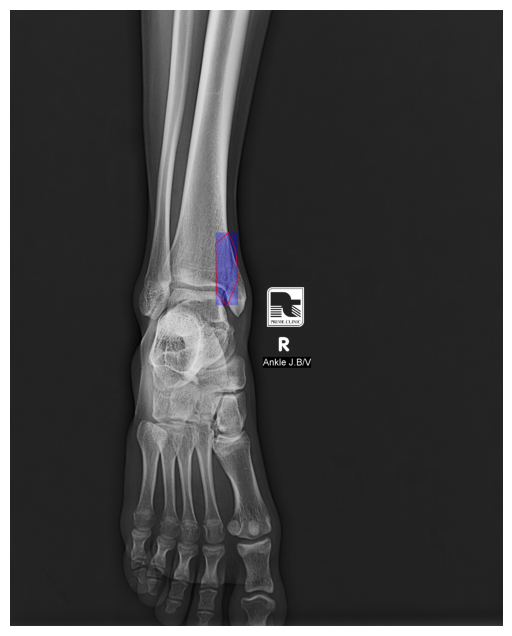

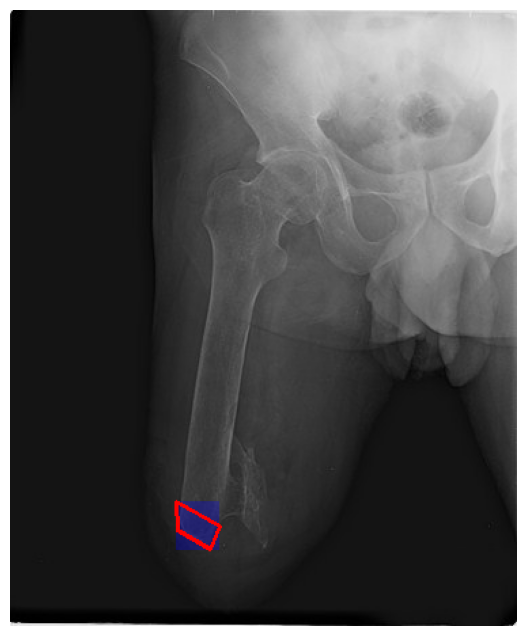

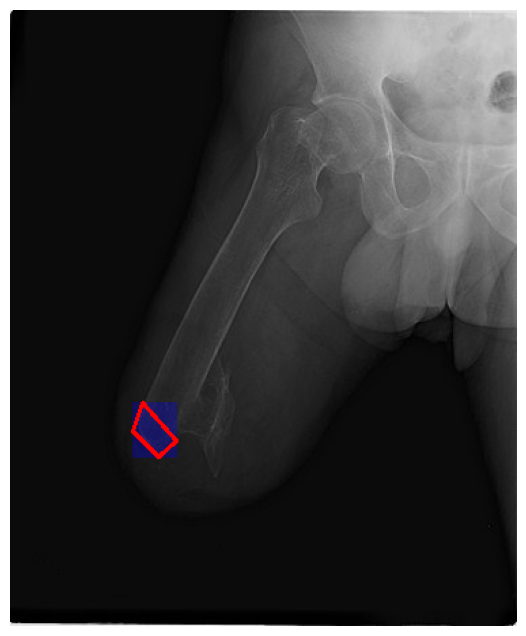

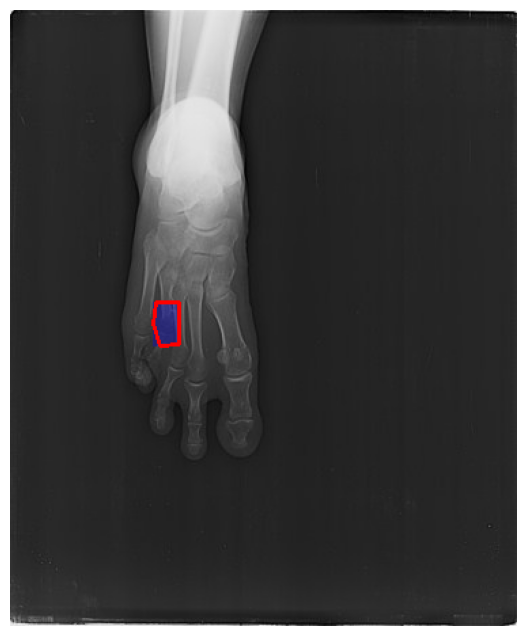

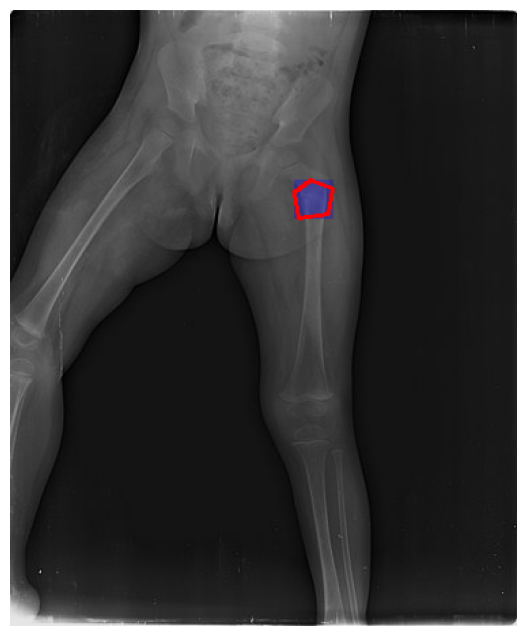

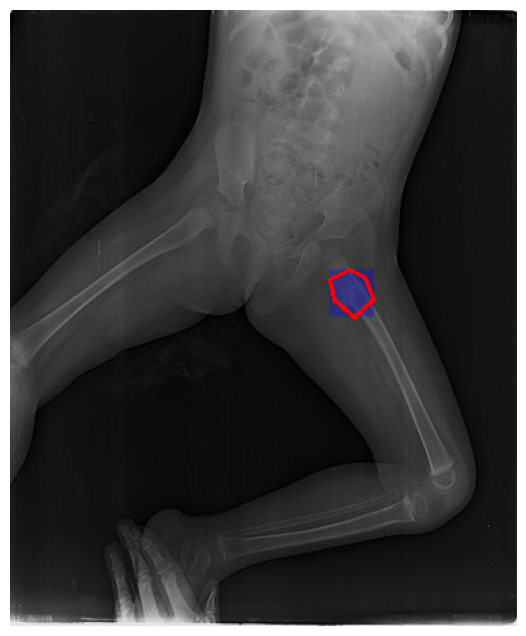

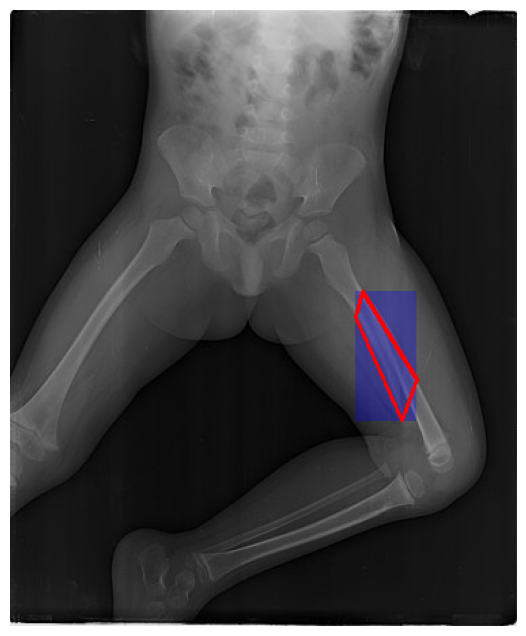

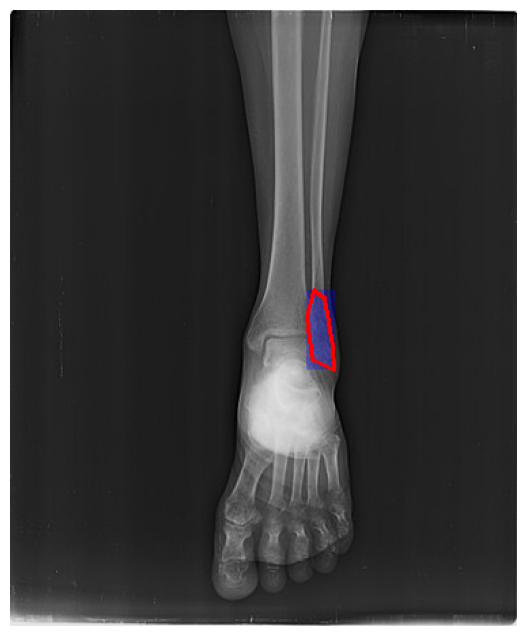

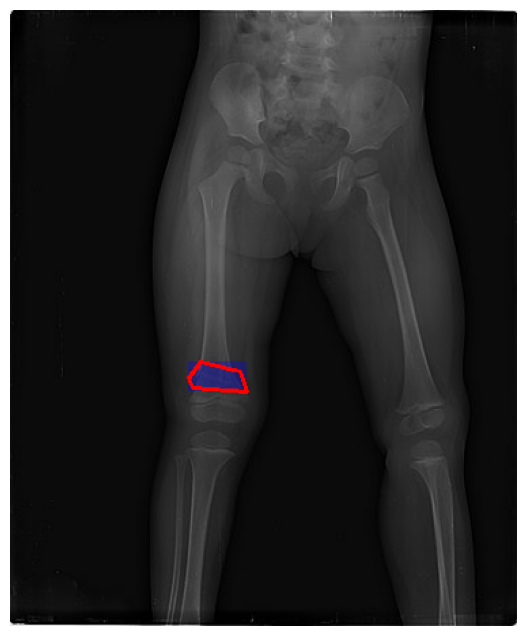

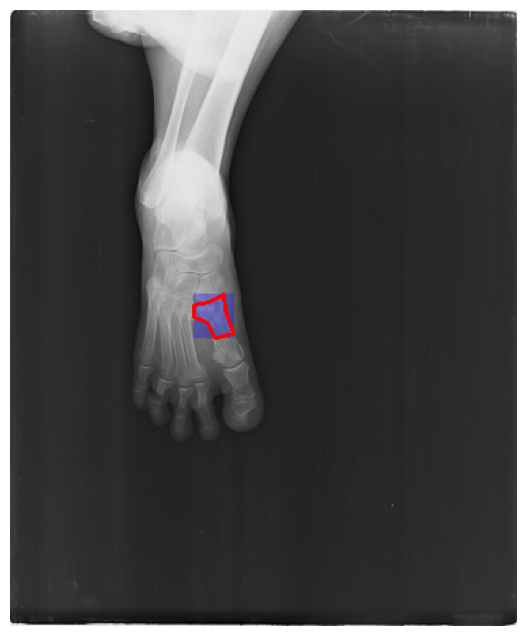

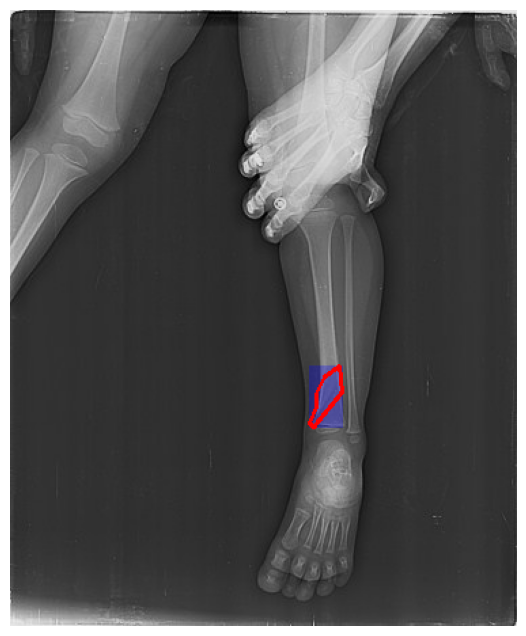

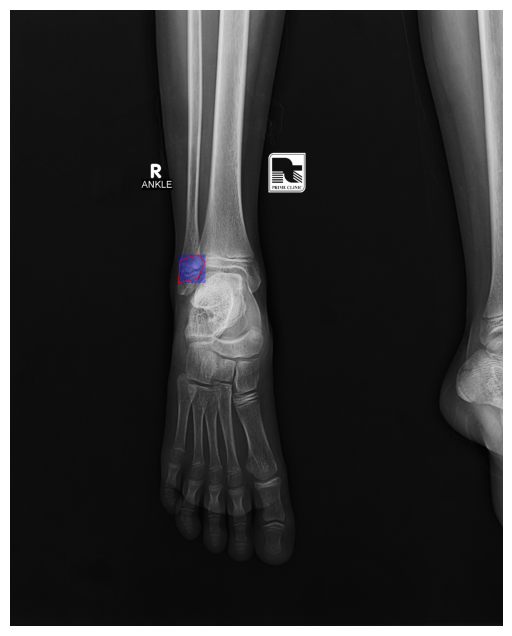

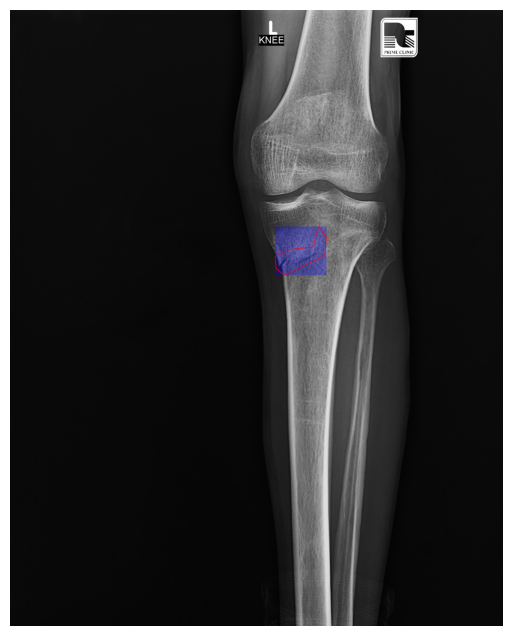

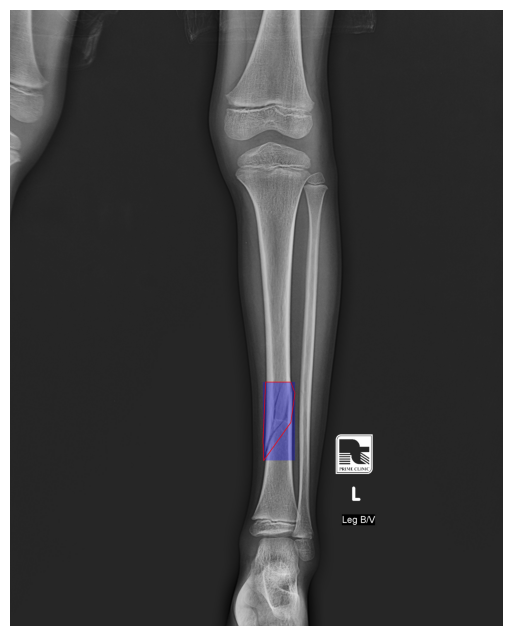

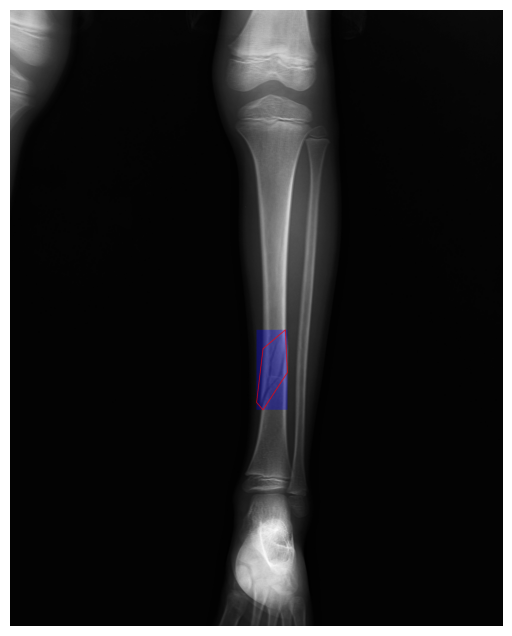

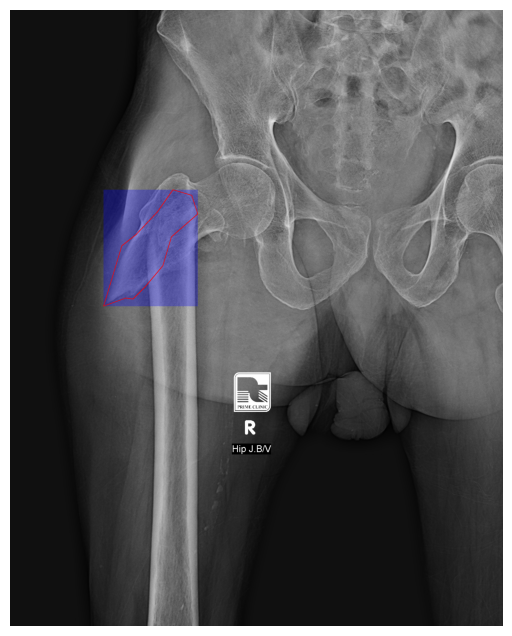

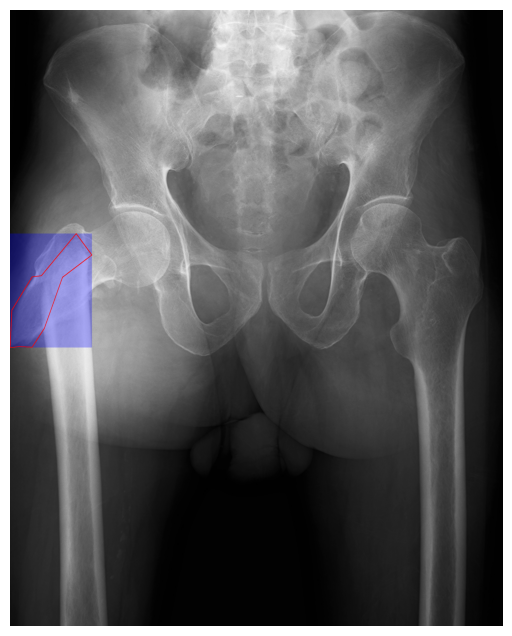

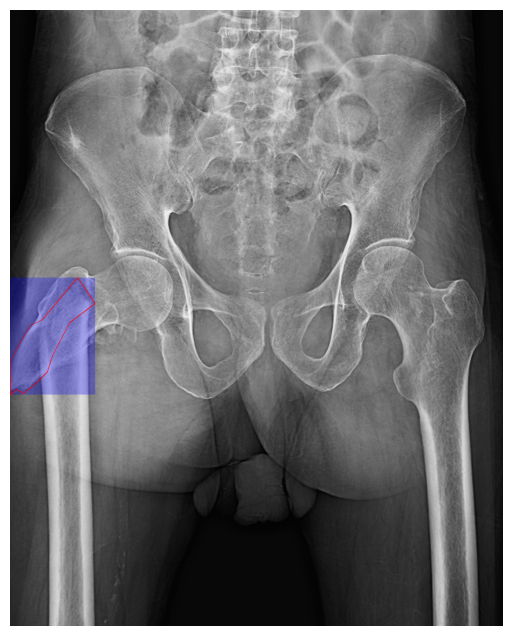

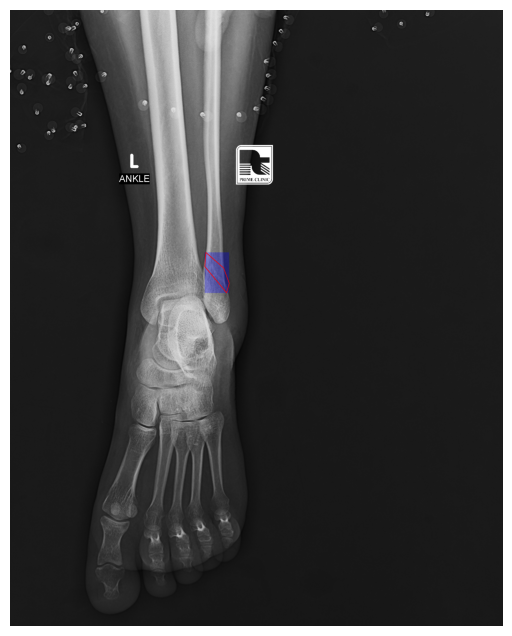

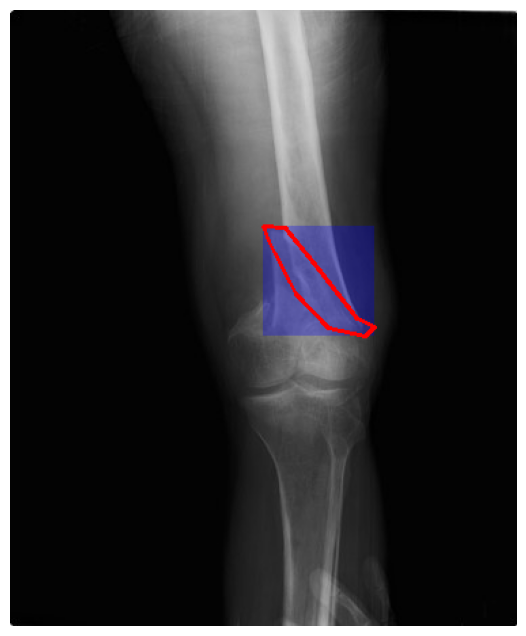

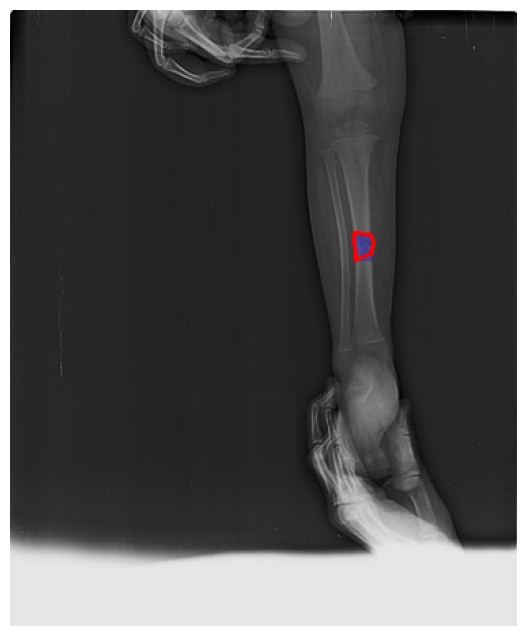

In [13]:
import cv2
# Function to add a translucent box on the image
def add_translucent_box(image, bbox):
    # Extract the coordinates and dimensions of the bbox
    x, y, width, height = bbox
    x, y, width, height = int(x), int(y), int(width), int(height)

    # Create a rectangle overlay with transparency
    overlay = image.copy()
    cv2.rectangle(overlay, (x, y), (x+width, y+height), (255, 0, 0), -1)  # Red rectangle with full opacity

    # Apply the overlay. 0.3 is the transparency factor
    image_new = cv2.addWeighted(overlay, 0.3, image, 0.7, 0)

    return image_new

# Load your CSV file into a DataFrame
df = pd.read_csv('FracAtlas/dataset.csv')

# Filter the DataFrame
filtered_df = df[(df['leg'] == 1) & (df['multiscan'] == 0) & (df['fracture_count'] <= 1) & (df['frontal'] == 1) & (df['hardware'] == 0)]

# Load and parse the COCO JSON file
with open(r'FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json', 'r') as file:  # Update the path to your JSON file
    data = json.load(file)

# Directory where the images are stored (update this path as necessary)
image_directory = 'FracAtlas/images/Fractured/'

# Process each image based on the annotations
count = 0
for annotation in data['annotations']:
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    segmentation = annotation['segmentation']
    
    # Find the corresponding image file
    image_info = next((item for item in data['images'] if item['id'] == image_id), None)
    if image_info:
        # Get all rows that match the file_name
        matches_df = filtered_df[filtered_df['image_id'] == image_info['file_name']]

        # Check if there are any matches
        if not matches_df.empty:
            corresponding_row = matches_df.iloc[0]  # Safely get the first row

            file_name = image_directory + image_info['file_name']
                    
            # Load the image
            img = cv2.imread(file_name, cv2.IMREAD_COLOR)
            if img is not None:
                # Add the translucent box
                img = add_translucent_box(img, bbox)
                for seg in segmentation:
                    pts = np.array(seg, np.int32).reshape((-1, 1, 2))
                    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)  # Red color


                # Show the image using Matplotlib
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
                count += 1
            else:
                print(f"Image {file_name} not found.")
    if count > 20:
        break